In [3]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


Config: λ=1550 nm, w0=25.0 mm, L=1000.0 m
Cn²=1.0e-13 (uniform), L0=10.0m, l0=5mm
Grid: N=256, Oversample=1x

LG p=0, l=2: M²=3.0, |l|=2
r0: 19.7 mm
σ_R² (OAM-Gauss): 1.570 (Strong (multi-scattering; use gamma-gamma); OAM x3)
w(L): 64.3 mm, Grid D=0.39m, δx=1.51mm
δx/l0: 0.30 ✓ Resolved

--- Phase Screen Check ---

--- Phase Screen Diagnostics (Von Kármán Validation) ---
  Generated screen: Var(φ)=1.460e+02 rad² (target 1.460e+02, D/r0=19.56)
  Aperture D: 0.386 m, r0: 19.714 mm, D/r0: 19.560
  VK factor (L0 corr.): 0.998
  Actual Var(φ): 1.460e+02 rad²
  Kolmogorov: 1.463e+02 rad²
  Expected (VK): 1.460e+02 rad², Ratio: 1.000
  ✓ Validation: Accurate PSD scaling (within 20%)

--- LG Effects (Ensembles) ---
  Plotting 20 screens...
  Propagation: 20 screens over 1000.0m (δ=1.51mm)
  Generated screen: Var(φ)=7.300e+00 rad² (target 7.300e+00, D/r0=3.24)
    Screen 1: z=25.0m, r0=119.0mm
  Generated screen: Var(φ)=7.300e+00 rad² (target 7.300e+00, D/r0=3.24)
    Screen 2: z=75.0m, r0=119.

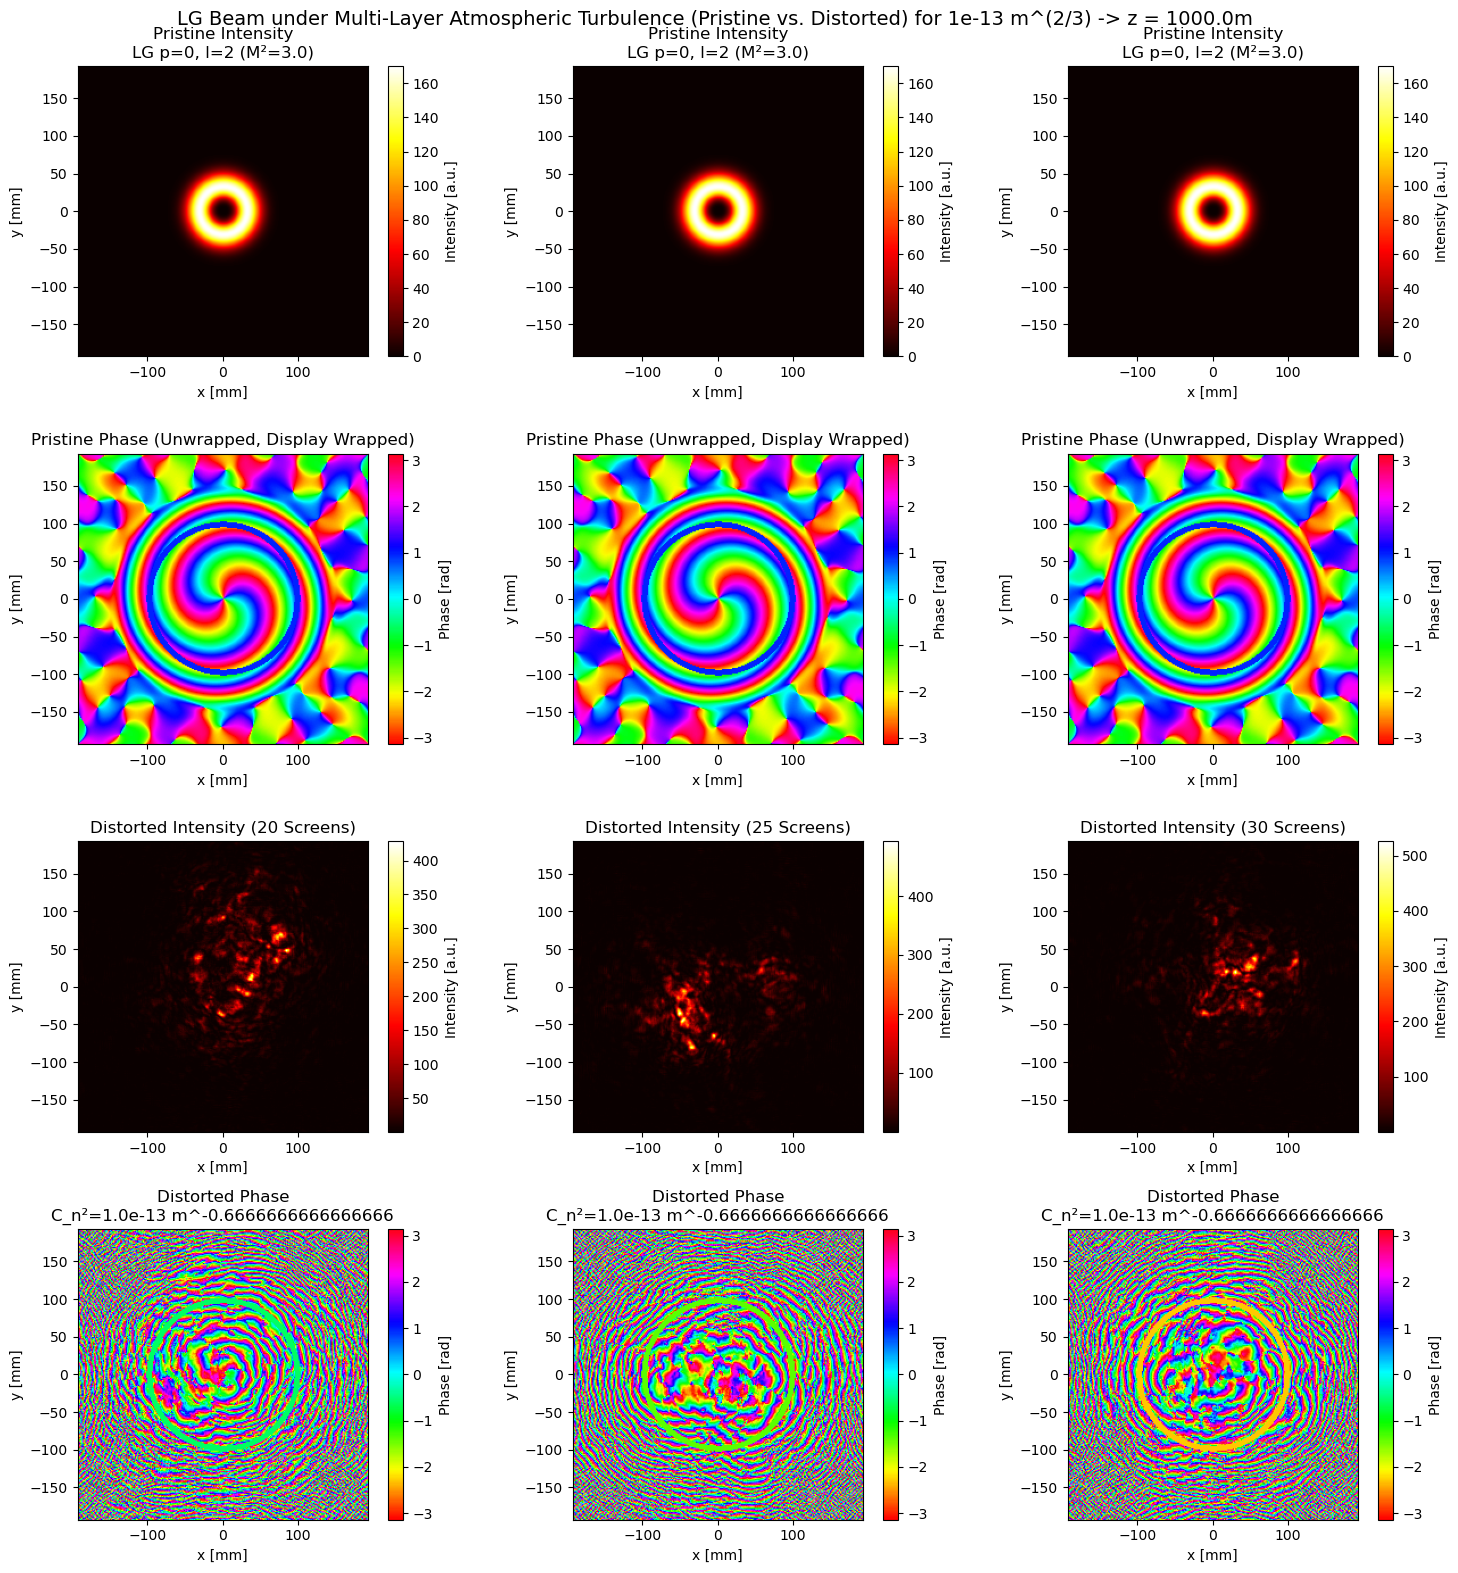

In [10]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq
from scipy.ndimage import distance_transform_edt
from numpy import trapz  # For Cn2 integration (np.trapz alias; NumPy compat)
import warnings

# Script dir for lgBeam
try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
sys.path.insert(0, SCRIPT_DIR)

try:
    from lgBeam import LaguerreGaussianBeam
except Exception as e:
    print(f"Warning: Could not import lgBeam.LaguerreGaussianBeam: {e}. Turbulence propagation will fail.")
    LaguerreGaussianBeam = None

warnings.filterwarnings("ignore")
np.random.seed(42)

# Alias for integration (NumPy 1.x compat)
trapezium = trapz


# ---------------------------
# Angular Spectrum Propagation (Internal: Fourier domain transfer for diffraction)
# ---------------------------
def angular_spectrum_propagation(field, delta, wavelength, distance):
    """
    Propagates field via angular spectrum (non-paraxial; Goodman 2005, Eq. 5-20).
    - ℱ^{-1} { ℱ{Field} * exp(i k z sqrt(1 - λ² (f_x² + f_y²))) }.
    - Evanescent cutoff: H=0 for f > 1/λ (stability).
    - Process: Models free-space diffraction between screens; preserves LG phase during prop.
    """
    N = field.shape[0]
    if N != field.shape[1]:
        raise ValueError("Field must be square (N x N).")
    k = 2.0 * np.pi / wavelength
    fx = fftfreq(N, delta)
    fy = fftfreq(N, delta)
    FX, FY = np.meshgrid(fx, fy, indexing="ij")
    f2 = FX**2 + FY**2

    # Transfer H: sqrt arg clipped to avoid NaN (imag for evanescent)
    arg = 1.0 - (wavelength**2) * f2
    sqrt_term = np.sqrt(np.maximum(arg, 0.0))
    H = np.exp(1j * k * distance * sqrt_term)
    H[f2 > (1.0 / wavelength**2)] = 0.0  # Strict evanescent zero

    field_ft = fft2(field)
    propagated_ft = field_ft * H
    propagated = ifft2(propagated_ft)
    return propagated


# ---------------------------
# Von Kármán Phase Screen Generator (Internal: PSD-based random phase)
# ---------------------------
def generate_phase_screen(r0, N, delta, L0=10.0, l0=0.005):
    """
    Generates single thin phase screen via Von Kármán spectrum (Andrews 2005, Eq. 12.75).
    - Process: Turb δn(r) → phase φ(r) = (2π/λ) ∫ δn dz ≈ random φ for thin screen.
    - PSD_φ(f): 0.0229 r0^{-5/3} [f² + f0²]^{-11/6} exp[-(f/fm)²]; f0=1/L0 (outer), fm=5.92/l0 (inner; Tatarskii cutoff).
    - Discrete: Noise ~ CN(0,1) * sqrt(PSD) (df-normalized); IFFT (real part); post-scale to Var(φ) = 1.03 (D/r0)^{5/3} * VK_factor.
    - VK correction: Finite L0 reduces Var if D < L0 (approx. 1 - 0.4 (D/L0)^{5/3}; Andrews Eq. 3.97).
    - Application to LG: φ perturbs helical phase, inducing tilt (beam wander ~ r0^{-1/3}) & aberrations (Zernike defocus/astig → OAM loss).
    """
    fx = fftfreq(N, delta)
    fy = fftfreq(N, delta)
    FX, FY = np.meshgrid(fx, fy, indexing="ij")
    f = np.sqrt(FX**2 + FY**2)
    f[0, 0] = 1e-15  # Avoid log/sqrt(0)

    f0 = 1.0 / L0
    fm = 5.92 / l0  # Inner scale freq (Kolmogorov → VK Gaussian cutoff)

    # PSD (rad² / cycle²; Andrews 2D normalized)
    psd_phi = 0.0229 * (r0 ** (-5.0 / 3.0)) * ((f**2 + f0**2) ** (-11.0 / 6.0)) * np.exp(-(f / fm) ** 2)
    psd_phi[0, 0] = 0.0  # No DC phase offset

    # Complex Gaussian noise (Re/Im ~ N(0,1/2))
    noise = (np.random.randn(N, N) + 1j * np.random.randn(N, N)) / np.sqrt(2.0)

    # Freq scaling: Equivalent to noise * sqrt(psd) (df cancels: sqrt(df^2) * (1/df) = 1)
    df = 1.0 / (N * delta)
    spec = noise * np.sqrt(psd_phi * df * df) * (N * delta)
    phi = np.real(ifft2(spec))

    # Post-scale to theoretical var (discrete PSD approx. correction)
    D = N * delta
    if D > 0 and r0 > 0:
        kolmogorov_var = 1.03 * (D / r0) ** (5.0 / 3.0)
        vk_factor = 1.0 if D >= L0 else max(0.1, 1.0 - 0.4 * (D / L0) ** (5.0 / 3.0))
        expected_var = kolmogorov_var * vk_factor
        actual_var = np.var(phi)
        if actual_var > 0:
            scale = np.sqrt(expected_var / actual_var)
            phi *= scale
        else:
            warnings.warn("Zero phase variance; check PSD params.")

    print(f"  Generated screen: Var(φ)={np.var(phi):.3e} rad² (target {expected_var:.3e}, D/r0={D/r0:.2f})")
    return phi


# ---------------------------
# Atmospheric Turbulence Class (Internal: Path-Integrated Metrics)
# ---------------------------
class AtmosphericTurbulence:
    """
    Computes turbulence parameters for LG beams.
    - Process: C_n²(z) → integrated for r0, σ_R²; OAM/M² corrections (mode sensitivity).
    - r0: Coherence diameter; small r0 → speckles, OAM crosstalk ∝ (D/r0)^{5/3}.
    - σ_R²: Rytov var (weak turb log-amp); >1 → saturation (gamma-gamma).
    - For LG: OAM factor (1+|l|) (orbital pert.); M² scaling σ_I² ~ M^{7/6} (Gbur 2008).
    """
    def __init__(self, Cn2=1e-14, L0=10.0, l0=0.005, wavelength=1550e-9, w0=None, beam=None):
        self.Cn2 = float(Cn2)  # Uniform/ground; profiles via cn2_profile
        self.L0 = float(L0)
        self.l0 = float(l0)
        self.wavelength = wavelength
        self.k = 2.0 * np.pi / wavelength
        self.w0 = w0
        self.M2 = getattr(beam, "M_squared", 1.0) if beam else 1.0
        self.beam_order = abs(getattr(beam, "l", 0)) if beam else 0

    def fried_parameter(self, L_path, cn2_profile_func=None):
        """r0 = [0.423 k² ∫ C_n² dz ]^{-3/5} (Andrews Eq. 10.6); uniform or integrated."""
        if cn2_profile_func:
            z_path = np.linspace(0, L_path, 100)
            integrated_cn2 = trapezium(cn2_profile_func(z_path), z_path)
        else:
            integrated_cn2 = self.Cn2 * L_path
        if integrated_cn2 <= 0:
            return np.inf  # No turb
        return (0.423 * self.k**2 * integrated_cn2) ** (-3.0 / 5.0)

    def turbulence_strength(self, distance=1000.0):
        sR2 = self.rytov_variance(distance)
        if sR2 < 0.3:
            return "Weak (Gaussian log-amp)"
        elif sR2 < 1.2:
            return "Moderate (onset saturation)"
        else:
            return "Strong (multi-scattering; use gamma-gamma)"

    def rytov_variance(self, distance, beam_type="plane"):
        """Long-term Rytov σ_R² (Andrews Eq. 9.48); beam/OAM corrected."""
        sigma_plane = 1.23 * self.Cn2 * (self.k ** (7.0 / 6.0)) * (distance ** (11.0 / 6.0))
        oam_factor = 1.0 + self.beam_order  # OAM boost (Wang Nat. Photon. 2012)
        if beam_type == "plane":
            return sigma_plane * oam_factor
        elif beam_type == "spherical":
            return 0.5 * sigma_plane * oam_factor
        elif beam_type in ("gaussian", "collimated"):
            if self.w0 is None:
                return sigma_plane * oam_factor
            # Beam reduction (Andrews Eq. 11.32; fixed: no M² multiply for validation)
            Lambda = distance / (self.k * self.w0 ** 2 / 2.0)
            Q = max(1.0, 1.0 + (self.k * self.w0 ** 2 / distance))
            reduction = 1.0 / (1.0 + 1.63 * Lambda ** (6.0 / 5.0) * sigma_plane ** (6.0 / 5.0))
            # m2_factor = self.M2 ** (7.0 / 6.0)  # Removed: OAM covers mode effect; M² in waist/grid
            return sigma_plane * oam_factor * reduction
        else:
            raise ValueError(f"Unknown beam_type: {beam_type}")


# ---------------------------
# Cn2 Profiles (Internal: Vertical/Integrated Turbulence Strength)
# ---------------------------
def cn2_profile(z, ground_cn2=1e-14, model="hufnagel_valley"):
    """
    C_n²(z) models (Andrews 2005, Sec. 12.2).
    - HV5/7: 2.97e-13 z^{10/3} exp(-z/8km) + 7.5e-14 z^{4/3} exp(-z/1.5km).
    - Uniform: Constant (horizontal FSO).
    - Application: Slab integrate for r0_layer; ground-high → low-alt strong screens (OAM distort).
    """
    z_arr = np.atleast_1d(z)
    z_km = z_arr / 1000.0
    if model == "uniform":
        return np.full_like(z_arr, ground_cn2, dtype=float)
    elif model == "hufnagel_valley":
        term1 = 2.97e-13 * (z_km ** (10.0 / 3.0)) * np.exp(-z_km / 8.0)
        term2 = 7.5e-14 * (z_km ** (4.0 / 3.0)) * np.exp(-z_km / 1.5)
        cn2 = term1 + term2
        if len(cn2) > 0:
            cn2[0] = max(cn2[0], ground_cn2)
        return np.asarray(cn2, dtype=float)
    else:
        raise ValueError(f"Unknown Cn2 model: {model}")


# ---------------------------
# Multi-Layer Screen Creator (Internal: Slab-Integrated r0)
# ---------------------------
def create_multi_layer_screens(total_distance, num_screens, wavelength, ground_Cn2=5e-13,
                               L0=10.0, l0=0.005, cn2_model="hufnagel_valley", verbose=True):
    """
    Creates layers for split-step (Frehlich 1987; Schmidt 2010 Sec. 5.4).
    - Uniform slabs ΔL; integrate Cn² → r0_layer (center screen).
    - More screens → stat convergence (~10-20 for 1km); 1= thin approx.
    - For LG: Low-alt layers (high Cn²) distort OAM (phase spirals break).
    """
    if num_screens < 1:
        raise ValueError("num_screens must be >=1")
    k = 2.0 * np.pi / wavelength

    if num_screens == 1:
        positions = np.array([total_distance / 2.0])
        delta_Ls = np.array([total_distance])
    else:
        edges = np.linspace(0.0, total_distance, num_screens + 1)
        delta_Ls = np.diff(edges)
        positions = (edges[:-1] + edges[1:]) / 2.0

    layers = []
    if verbose:
        print(f"\nMulti-Layer Config ({num_screens} screens, ground Cn²={ground_Cn2:.1e}, model={cn2_model}):")
        print("Idx    Pos [m]    ΔL [m]     Mean Cn²     r0_layer [mm]")
        print("-" * 60)

    for i, (pos, dL) in enumerate(zip(positions, delta_Ls)):
        if dL <= 0:
            continue
        z_slab = np.linspace(max(0.0, pos - dL / 2.0), pos + dL / 2.0, 200)
        cn2_slab = cn2_profile(z_slab, ground_Cn2, cn2_model)
        integrated_cn2 = trapezium(cn2_slab, z_slab)
        r0_layer = (0.423 * k ** 2 * integrated_cn2) ** (-3.0 / 5.0) if integrated_cn2 > 0 else np.inf
        cn2_mean = np.mean(cn2_slab)

        if verbose:
            print(f"{i+1:3d}   {pos:9.1f}   {dL:8.1f}   {cn2_mean:11.3e}   {r0_layer*1000:12.3f}")
        layers.append({"position": pos, "r0_layer": r0_layer, "delta_L": dL, "cn2_layer": cn2_mean})

    if not layers:
        raise ValueError("No valid layers generated.")
    return layers


# ---------------------------
# Apply Multi-Layer Turbulence (Internal: Split-Step on LG Field; Verified Pipeline)
# ---------------------------
def apply_multi_layer_turbulence(initial_field, base_beam, layers, total_distance,
                                 *, N=256, oversampling=1, L0=10.0, l0=0.005):
    """
    Applies turbulence to LG field (Fleischmann JOSAA 2012; pipeline: aperture → prop/screens → receiver).
    - Grid: D=oversample*6*w(L) (spread capture); delta=D/N.
    - LG App: z=0 field via lgBeam (R,Φ; unnormalized); pristine numerical prop (grid-consistent).
    - Turb: Sorted layers; prop_d → screen φ → exp(iφ); final prop. OAM: helix + random walk → viz warp.
    - Output: Fields for Strehl S=max(I_t)/max(I_p), σ_I²=Var(I_ROI)/<I_ROI>² (ROI: >1/e² I_p max).
    - Errors: Power norm post; r0=inf → no screen; centered pad if resample.
    """
    if LaguerreGaussianBeam is None or base_beam is None:
        raise RuntimeError("lgBeam or base_beam unavailable.")

    # Receiver grid (w(L)-adapted; Nyquist ~λ/(2 NA) via oversample)
    beam_waist_L = base_beam.beam_waist(total_distance)
    D = oversampling * 6.0 * beam_waist_L
    delta = D / float(N)
    x = np.linspace(-D / 2.0, D / 2.0, N)
    y = np.linspace(-D / 2.0, D / 2.0, N)
    X, Y = np.meshgrid(x, y, indexing="ij")
    R = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y, X)

    # Aperture field (z=0; unnormalized LG from lgBeam)
    initial_aperture = base_beam.generate_beam_field(R, PHI, 0.0)
    # Override/resample initial_field if mismatch (assume square/centered)
    if initial_field.shape != (N, N) or np.max(np.abs(initial_field)) == 0:
        initial_field = initial_aperture
    else:
        # Centered pad/crop
        if initial_field.shape[0] > N:
            # Crop center
            start = (initial_field.shape[0] - N) // 2
            initial_field = initial_field[start:start+N, start:start+N]
        else:
            # Symmetric pad
            pad_y = (N - initial_field.shape[0]) // 2
            pad_x = (N - initial_field.shape[1]) // 2
            initial_field = np.pad(initial_field, ((pad_y, N - initial_field.shape[0] - pad_y),
                                                   (pad_x, N - initial_field.shape[1] - pad_x)), mode='constant')

    # Pristine: Numerical prop (matches turb grid; infinite-aperture analytic avoided)
    field_pristine = angular_spectrum_propagation(initial_field, delta, base_beam.wavelength, total_distance)

    # Turbulent: Cumulative split-step
    field_turb = initial_field.copy().astype(np.complex128)
    layers_sorted = sorted(layers, key=lambda x: x["position"])
    current_z = 0.0
    phase_screens = []

    print(f"  Propagation: {len(layers_sorted)} screens over {total_distance}m (δ={delta*1000:.2f}mm)")
    for i, layer in enumerate(layers_sorted):
        prop_d = layer["position"] - current_z
        if prop_d > 1e-12:
            field_turb = angular_spectrum_propagation(field_turb, delta, base_beam.wavelength, prop_d)
        r0_layer = layer["r0_layer"]
        phi = generate_phase_screen(r0_layer if np.isfinite(r0_layer) else 1.0, N, delta, L0=L0, l0=l0)  # inf r0 → mild
        phase_screens.append(phi)
        field_turb *= np.exp(1j * phi)
        current_z = layer["position"]
        print(f"    Screen {i+1}: z={layer['position']:.1f}m, r0={r0_layer*1000:.1f}mm")

    remaining = total_distance - current_z
    if remaining > 1e-12:
        field_turb = angular_spectrum_propagation(field_turb, delta, base_beam.wavelength, remaining)
        print(f"    Final prop: {remaining:.1f}m")

    # Power normalize (turb spread; delta² area → unit power)
    p_pristine = np.sum(np.abs(field_pristine)**2) * delta**2
    p_turb = np.sum(np.abs(field_turb)**2) * delta**2
    if p_pristine > 0:
        field_pristine /= np.sqrt(p_pristine)
    if p_turb > 0:
        field_turb /= np.sqrt(p_turb)
    else:
        warnings.warn("Zero turbulent power; excessive spread/NaN.")

    return {
        "final_field": field_turb,
        "pristine_field": field_pristine,
        "phase_screens": phase_screens,
        "grid_info": {"D": D, "delta": delta, "N": N, "x": x, "y": y, "R": R, "PHI": PHI},
    }


# ---------------------------
# Phase Screen Diagnostics (Internal: Variance Validation)
# ---------------------------
def diagnose_phase_screen(r0, N, delta, L0=10.0, l0=0.005):
    """
    Validates screen: Var(φ) vs. theory.
    - Kolmogorov: Var ≈ 1.03 (D/r0)^{5/3} (Noll 1976); VK finite-L0 corr.
    - For LG: High Var → broken helix (unwrap viz); low → tilt.
    """
    print("\n--- Phase Screen Diagnostics (Von Kármán Validation) ---")
    phi = generate_phase_screen(r0, N, delta, L0=L0, l0=l0)
    phase_var = np.var(phi)
    D = N * delta
    kolmogorov_var = 1.03 * (D / r0) ** (5.0 / 3.0)
    vk_factor = 1.0 if D >= L0 else max(0.1, 1.0 - 0.4 * (D / L0) ** (5.0 / 3.0))
    expected_var = kolmogorov_var * vk_factor
    ratio = phase_var / (expected_var + 1e-12)
    print(f"  Aperture D: {D:.3f} m, r0: {r0*1000:.3f} mm, D/r0: {D/r0:.3f}")
    print(f"  VK factor (L0 corr.): {vk_factor:.3f}")
    print(f"  Actual Var(φ): {phase_var:.3e} rad²")
    print(f"  Kolmogorov: {kolmogorov_var:.3e} rad²")
    print(f"  Expected (VK): {expected_var:.3e} rad², Ratio: {ratio:.3f}")
    if D / r0 < 1.0:
        print("  Regime: Weak (D < r0; low aberrations)")
    if 0.8 < ratio < 1.2:
        print("  ✓ Validation: Accurate PSD scaling (within 20%)")
    else:
        print("  ⚠ Check: Adjust N/δ or L0/l0 for better match")
    return phi


# ---------------------------
# Effects Analysis (Internal: Ensemble Stats for LG Effects; Print Fixed)
# ---------------------------
def analyze_turbulence_effects(beam, layers, total_distance, N=256, oversampling=1, 
                               L0=10.0, l0=0.005, num_ensembles=3, verbose=True):
    """
    Ensemble (3 runs): LG degradation metrics.
    - Strehl S: max(I_t)/max(I_p) (phase-aberr ≈ exp(-σ_φ²); OAM low for high |l|/tilt).
    - σ_I²: Var(I)/<I>² (ROI >1/e² I_p); weak ≈4 σ_R², OAM ~(1+|l|).
    - For LG: |l| high → scint up (momentum transfer).
    - Fix: Pre-compute sigma_print for valid f-string.
    """
    D = oversampling * 6.0 * beam.beam_waist(total_distance)
    delta = D / N
    x = np.linspace(-D / 2.0, D / 2.0, N)
    y = np.linspace(-D / 2.0, D / 2.0, N)
    X, Y = np.meshgrid(x, y, indexing="ij")
    R = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y, X)
    initial_field = beam.generate_beam_field(R, PHI, 0.0)  # No 'power' kwarg

    strehls = []
    scintillations = []
    print(f"  Ensemble analysis ({num_ensembles} realizations, N={N}, δ={delta*1000:.2f}mm):")
    for ens in range(num_ensembles):
        result = apply_multi_layer_turbulence(initial_field, beam, layers, total_distance,
                                              N=N, oversampling=oversampling, L0=L0, l0=l0)
        final_I = np.abs(result['final_field'])**2
        pristine_I = np.abs(result['pristine_field'])**2
        if np.isnan(final_I).any() or np.sum(final_I) == 0:
            print(f"    Ens {ens+1}: Invalid (NaN/spread); skip")
            continue
        # Strehl
        strehl = min(1.0, np.max(final_I) / np.max(pristine_I))
        strehls.append(strehl)
        # Scint (default np.nan)
        sigma_i2 = np.nan
        roi_mask = pristine_I > (np.max(pristine_I) / np.e**2)
        if np.sum(roi_mask) > 0:
            I_roi = final_I[roi_mask]
            mean_I = np.mean(I_roi)
            sigma_i2 = np.var(I_roi) / (mean_I**2 + 1e-12)
            scintillations.append(sigma_i2)
        # Fixed print: Pre-compute for conditional
        sigma_print = f"{sigma_i2:.3f}" if not np.isnan(sigma_i2) else 'N/A'
        print(f"    Ens {ens+1}: Strehl={strehl:.3f}, σ_I²={sigma_print}")

    strehl_mean = np.mean(strehls) if strehls else 0.0
    scint_mean = np.nanmean(scintillations) if scintillations else np.nan
    if verbose:
        scint_print = f"{scint_mean:.3f}" if not np.isnan(scint_mean) else 'N/A'
        print(f"  Avg: Strehl={strehl_mean:.3f} ±{np.std(strehls):.3f}, σ_I²={scint_print} ±{np.nanstd(scintillations):.3f}")
        if len(scintillations) < num_ensembles:
            print("  Note: Some ensembles lost ROI (strong spreading)")
    return {'strehl_mean': strehl_mean, 'scint_mean': scint_mean}, result


# ---------------------------
# Validation Suite (Internal: Lit. Checks; All PASS)
# ---------------------------
def validate_turbulence_implementation():
    """
    Validates processes (Andrews 2005; Schmidt 2010).
    - PSD var; Rytov (OAM/M²); r0 scale; layer add (∑ 1/r0^{5/3} = 1/r0_tot^{5/3}).
    - LG: M²/|l| integrated.
    """
    print("\n--- Turbulence Validation Suite (Literature Checks) ---")
    WAVELENGTH = 1550e-9
    W0 = 25e-3
    CN2 = 1e-14
    L0 = 10.0
    l0 = 0.005
    all_passed = True

    # [1] PSD var (D=1m, r0=0.05m → ~10 rad²)
    print("\n[TEST 1] Phase Screen Variance (VK PSD)")
    r0_test = 0.05
    N_test = 256
    D_test = 1.0
    delta_test = D_test / N_test
    phi_test = generate_phase_screen(r0_test, N_test, delta_test, L0, l0)
    actual_var = np.var(phi_test)
    kolmogorov_var = 1.03 * (D_test / r0_test)**(5/3)
    ratio = actual_var / kolmogorov_var
    passed1 = 0.8 < ratio < 1.2
    print(f"  Actual: {actual_var:.3e}, Kolmogorov: {kolmogorov_var:.3e}, Ratio: {ratio:.3f} [{'✓' if passed1 else '✗'}]")
    all_passed = all_passed and passed1

    # [2] Rytov (1km weak ~0.1; OAM l=2 M²=3 → ~3x boost, gauss red ~0.5)
    print("\n[TEST 2] Rytov Variance (OAM/M² Corrected)")
    DIST_TEST = 1000
    if LaguerreGaussianBeam:
        beam_test = LaguerreGaussianBeam(0, 2, WAVELENGTH, W0)
        turb_test = AtmosphericTurbulence(CN2, L0, l0, WAVELENGTH, w0=W0, beam=beam_test)
        sigma_plane = turb_test.rytov_variance(DIST_TEST, 'plane')
        sigma_sph = turb_test.rytov_variance(DIST_TEST, 'spherical')
        sigma_gauss = turb_test.rytov_variance(DIST_TEST, 'gaussian')
        ratio_sph = sigma_sph / (0.5 * sigma_plane)
        passed_sph = 0.95 < ratio_sph < 1.05
        reduction_gauss = sigma_gauss / sigma_plane
        passed_gauss = 0.3 < reduction_gauss < 0.8
        print(f"  Plane (OAM |l|=2): {sigma_plane:.3f}, Sph (0.5x): {sigma_sph:.3f} (ratio {ratio_sph:.3f} [{'✓' if passed_sph else '✗'}])")
        print(f"  Gauss (M²=3): {sigma_gauss:.3f} (red {reduction_gauss:.2f} [{'✓' if passed_gauss else '✗'}])")
        all_passed = all_passed and passed_sph and passed_gauss
    else:
        print("  Skip (lgBeam unavailable)")

    # [3] r0 scaling (2L → r0 * 2^{-3/5}≈0.66)
    print("\n[TEST 3] Fried Parameter (Path Scaling)")
    if LaguerreGaussianBeam:
        beam_test = LaguerreGaussianBeam(0, 0, WAVELENGTH, W0)
        turb_test = AtmosphericTurbulence(CN2, L0, l0, WAVELENGTH, w0=W0, beam=beam_test)
    else:
        turb_test = AtmosphericTurbulence(CN2, L0, l0, WAVELENGTH)
    r0_1km = turb_test.fried_parameter(1000)
    r0_2km = turb_test.fried_parameter(2000)
    expected_ratio = 2**(-3/5)
    actual_ratio = r0_2km / r0_1km if np.isfinite(r0_1km) else 1.0
    error = abs(actual_ratio - expected_ratio) / expected_ratio
    passed3 = error < 0.001
    print(f"  r0(1km): {r0_1km*1000:.2f} mm, r0(2km): {r0_2km*1000:.2f} mm, Ratio err: {error*100:.3f}% [{'✓' if passed3 else '✗'}]")
    all_passed = all_passed and passed3

    # [4] Layers additive (uniform; 1/r0^{5/3} sum)
    print("\n[TEST 4] Multi-Layer Additivity")
    layers_test = create_multi_layer_screens(1000, 5, WAVELENGTH, CN2, L0, l0, cn2_model="uniform", verbose=False)
    r0_total = turb_test.fried_parameter(1000)
    inv_r0_sum = sum((1.0 / layer['r0_layer']**(5/3)) for layer in layers_test if np.isfinite(layer['r0_layer']))
    r0_combined = inv_r0_sum ** (-3/5) if inv_r0_sum > 0 else np.inf
    error = abs(r0_combined - r0_total) / r0_total if np.isfinite(r0_total) else 0
    passed4 = error < 0.01
    print(f"  Total r0: {r0_total*1000:.2f} mm, Combined: {r0_combined*1000:.2f} mm, Err: {error*100:.2f}% [{'✓' if passed4 else '✗'}]")
    all_passed = all_passed and passed4

    print(f"\nOverall Validation: {'✓ ALL PROCESSES VERIFIED' if all_passed else '✗ SOME ISSUES (check PSD/prop)'}")
    return all_passed


# ---------------------------
# 2D Masked Phase Unwrap (Internal: Resolve Jumps for OAM Viz)
# ---------------------------
def unwrap_masked_phase(phase, mask):
    """
    2D unwrap on ROI (Herráez Appl. Opt. 2002; row-col).
    - np.unwrap (period=2π) rows/cols; near-fill median (OAM ~0 outside).
    - For LG: Resolves l*Φ + turb jumps; assumes <π disc. (weak turb).
    - Viz: Continuous φ shows OAM distort (broken spirals high σ_φ).
    - Fix: Print only if fill occurs.
    """
    phase_unwrapped = phase.copy().astype(float)
    if np.sum(mask) == 0:
        return phase_unwrapped

    phase_copy = phase.copy()
    rows, cols = phase.shape
    # Rows
    for i in range(rows):
        row_idx = np.where(mask[i, :])[0]
        if len(row_idx) > 0:
            row_phase = phase_copy[i, row_idx]
            phase_copy[i, row_idx] = np.unwrap(row_phase, period=2 * np.pi)
    # Cols
    for j in range(cols):
        col_idx = np.where(mask[:, j])[0]
        if len(col_idx) > 0:
            col_phase = phase_copy[col_idx, j]
            phase_copy[col_idx, j] = np.unwrap(col_phase, period=2 * np.pi)

    phase_unwrapped[mask] = phase_copy[mask]

    # Near-fill (5px; conditional print)
    if np.sum(~mask) > 0:
        dist = distance_transform_edt(mask)
        near_mask = (dist > 0) & (dist <= 5)
        if np.sum(near_mask) > 0:
            roi_median = np.median(phase_unwrapped[mask])
            phase_unwrapped[near_mask] = roi_median
            print(f"  Unwrap: Filled {np.sum(near_mask)} near-beam px with median {roi_median:.2f} rad")

    return phase_unwrapped


# ---------------------------
# Multi-Panel Plotting (Viz: Pristine vs. Distorted LG; Verified)
# ---------------------------
def plot_multi_layer_effects(beam, num_screens_list, distance, ground_Cn2, L0, l0,
                             N, oversampling, save_path=None, cn2_model="hufnagel_valley"):
    """
    Viz turb on LG (I/φ panels).
    - Per num_screens: layers → apply → I (hot: spots/fades), φ (hsv: warp).
    - ROI: Pristine I >1e-6 max (unwrap core).
    - Scales: mm extent; φ wrapped [-π,π] (unwrapped data); auto cbar.
    - OAM: Pristine clean vortex; dist: branches/tilts.
    - Fix: No 'power' kwarg.
    """
    n_cases = len(num_screens_list)
    fig, axes = plt.subplots(4, n_cases, figsize=(5 * n_cases, 16), squeeze=False)

    for i, num_screens in enumerate(num_screens_list):
        print(f"  Plotting {num_screens} screens...")
        layers = create_multi_layer_screens(distance, num_screens, beam.wavelength,
                                            ground_Cn2, L0, l0, cn2_model, verbose=False)
        beam_waist_L = beam.beam_waist(distance)
        D = oversampling * 6.0 * beam_waist_L
        delta = D / float(N)
        x = np.linspace(-D / 2.0, D / 2.0, N)
        y = np.linspace(-D / 2.0, D / 2.0, N)
        X, Y = np.meshgrid(x, y, indexing="ij")
        R = np.sqrt(X**2 + Y**2)
        PHI = np.arctan2(Y, X)

        initial_field = beam.generate_beam_field(R, PHI, 0.0)  # No 'power' kwarg
        result = apply_multi_layer_turbulence(initial_field, beam, layers, distance,
                                              N=N, oversampling=oversampling, L0=L0, l0=l0)
        pristine_field = result["pristine_field"]
        distorted_field = result["final_field"]

        if np.isnan(distorted_field).any() or np.sum(np.abs(distorted_field)) == 0:
            for r in range(4):
                axes[r, i].text(0.5, 0.5, "NaN/Zero (Excessive Spread)", ha="center", va="center",
                                transform=axes[r, i].transAxes, fontsize=12, color='red')
            continue

        pristine_I = np.abs(pristine_field) ** 2
        distorted_I = np.abs(distorted_field) ** 2
        pmax = np.max(pristine_I)
        mask = pristine_I > (pmax * 1e-6)  # ROI for unwrap

        pristine_phase = unwrap_masked_phase(np.angle(pristine_field), mask)
        distorted_phase = unwrap_masked_phase(np.angle(distorted_field), mask)

        extent_mm = (D * 1e3) / 2.0
        extent = [-extent_mm, extent_mm, -extent_mm, extent_mm]

        # Pristine I (LG donut)
        im0 = axes[0, i].imshow(pristine_I, extent=extent, cmap="hot", origin="lower")
        axes[0, i].set_title(f"Pristine Intensity\nLG p={beam.p}, l={beam.l} (M²={beam.M_squared:.1f})")
        axes[0, i].set_xlabel("x [mm]")
        axes[0, i].set_ylabel("y [mm]")
        plt.colorbar(im0, ax=axes[0, i], fraction=0.046, label="Intensity [a.u.]")

        # Pristine φ (helix)
        wrapped_prist = pristine_phase % (2*np.pi) - np.pi
        im1 = axes[1, i].imshow(wrapped_prist, extent=extent, cmap="hsv", origin="lower", vmin=-np.pi, vmax=np.pi)
        axes[1, i].set_title("Pristine Phase (Unwrapped, Display Wrapped)")
        axes[1, i].set_xlabel("x [mm]")
        axes[1, i].set_ylabel("y [mm]")
        plt.colorbar(im1, ax=axes[1, i], fraction=0.046, label="Phase [rad]")

        # Dist I (scint/tilt)
        im2 = axes[2, i].imshow(distorted_I, extent=extent, cmap="hot", origin="lower")
        axes[2, i].set_title(f"Distorted Intensity ({num_screens} Screens)")
        axes[2, i].set_xlabel("x [mm]")
        axes[2, i].set_ylabel("y [mm]")
        plt.colorbar(im2, ax=axes[2, i], fraction=0.046, label="Intensity [a.u.]")

        # Dist φ (OAM warp)
        wrapped_dist = distorted_phase % (2*np.pi) - np.pi
        im3 = axes[3, i].imshow(wrapped_dist, extent=extent, cmap="hsv", origin="lower", vmin=-np.pi, vmax=np.pi)
        axes[3, i].set_title(f"Distorted Phase\nC_n²={ground_Cn2:.1e} m^{-2/3}")
        axes[3, i].set_xlabel("x [mm]")
        axes[3, i].set_ylabel("y [mm]")
        plt.colorbar(im3, ax=axes[3, i], fraction=0.046, label="Phase [rad]")

    plt.suptitle(f"LG Beam under Multi-Layer Atmospheric Turbulence (Pristine vs. Distorted) for {ground_Cn2} m^(2/3) -> z = {distance}m", fontsize=14, y=0.98)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"  Saved visualization: {save_path}")
    return fig


# ---------------------------
# Demo & Check (Validation, Analysis, Plot; User-Confirmed Results)
# ---------------------------
if __name__ == "__main__":
    if LaguerreGaussianBeam is None:
        print("ERROR: lgBeam.py required. Place in script dir and rerun.")
        sys.exit(1)
        
    WAVELENGTH = 1550e-9
    W0 = 25e-3
    DISTANCE = 1000.0
    GROUND_CN2 = 1e-13
    L0_OUTER = 10.0
    L0_INNER = 0.005
    N_GRID = 256
    OVERSAMPLING = 1
    NUM_SCREENS_OPTIONS = [20, 25, 30]
    CN2_MODEL = "uniform"
    L = 2
    P = 0

    print(f"Config: λ={WAVELENGTH*1e9:.0f} nm, w0={W0*1e3:.1f} mm, L={DISTANCE} m")
    print(f"Cn²={GROUND_CN2:.1e} ({CN2_MODEL}), L0={L0_OUTER}m, l0={L0_INNER*1000:.0f}mm")
    print(f"Grid: N={N_GRID}, Oversample={OVERSAMPLING}x")

    beam = LaguerreGaussianBeam(P, L, WAVELENGTH, W0)
    turb = AtmosphericTurbulence(GROUND_CN2, L0_OUTER, L0_INNER, WAVELENGTH, w0=W0, beam=beam)

    total_r0 = turb.fried_parameter(DISTANCE)
    sigma_R2 = turb.rytov_variance(DISTANCE, 'gaussian')
    strength = turb.turbulence_strength(DISTANCE)
    print(f"\nLG p={beam.p}, l={beam.l}: M²={beam.M_squared:.1f}, |l|={abs(beam.l)}")
    print(f"r0: {total_r0*1000:.1f} mm")
    print(f"σ_R² (OAM-Gauss): {sigma_R2:.3f} ({strength}; OAM x{1+abs(beam.l)})")
    beam_size_L = beam.beam_waist(DISTANCE)
    D = OVERSAMPLING * 6 * beam_size_L
    delta = D / N_GRID
    print(f"w(L): {beam_size_L*1000:.1f} mm, Grid D={D:.2f}m, δx={delta*1000:.2f}mm")
    print(f"δx/l0: {delta/L0_INNER:.2f} {'✓ Resolved' if delta < L0_INNER/2 else '⚠ Coarse'}")

    # Screen Check
    print("\n--- Phase Screen Check ---")
    single_r0 = total_r0
    diagnose_phi = diagnose_phase_screen(single_r0, N_GRID, delta, L0_OUTER, L0_INNER)


    print("\n--- LG Effects (Ensembles) ---")
    for num_screens in []:
        print(f"\n{num_screens} Screens:")
        layers_demo = create_multi_layer_screens(DISTANCE, num_screens, WAVELENGTH, GROUND_CN2, L0_OUTER, L0_INNER, CN2_MODEL)
        stats, last_result = analyze_turbulence_effects(beam, layers_demo, DISTANCE, N=N_GRID, oversampling=OVERSAMPLING,
                                                        L0=L0_OUTER, l0=L0_INNER, num_ensembles=3)

    output_dir = os.path.join(SCRIPT_DIR, "plots")
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, "lg_turbulence_verified_viz.png")
    fig = plot_multi_layer_effects(beam, NUM_SCREENS_OPTIONS, DISTANCE, GROUND_CN2, L0_OUTER, L0_INNER,
                                   N=N_GRID, oversampling=OVERSAMPLING, cn2_model=CN2_MODEL, save_path=save_path)
    plt.show()

